Import Packages

In [1]:
import open3d as o3d
import cv2
import numpy as np

Mount the Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PCD File

In [3]:
dataset_path = "/content/drive/MyDrive/6 DoF Pose Estimation/cereal_box_1/full/cereal_box_1_1_1.pcd"
cloud = o3d.io.read_point_cloud(dataset_path) # Read the point cloud
#o3d.visualization.draw_plotly([cloud])

Load the images

In [ ]:
im01="/content/drive/MyDrive/6 DoF Pose Estimation/background_1/full/background_1_1_1.pcd"
im02="/content/drive/MyDrive/6 DoF Pose Estimation/background_1/full/background_1_1_2.pcd"
im03="/content/drive/MyDrive/6 DoF Pose Estimation/background_1/full/background_1_1_3.pcd"
im04="/content/drive/MyDrive/6 DoF Pose Estimation/background_1/full/background_1_1_4.pcd"
im05="/content/drive/MyDrive/6 DoF Pose Estimation/background_1/full/background_1_1_5.pcd"


In [ ]:
pcd1 = o3d.io.read_point_cloud(im01)
pcd2 = o3d.io.read_point_cloud(im02)
pcd3 = o3d.io.read_point_cloud(im03)
pcd4 = o3d.io.read_point_cloud(im04)
pcd5 = o3d.io.read_point_cloud(im05)
pcd_file=[pcd1,pcd2,pcd3,pcd4,pcd5]


**Find Refernce Image**

In [5]:
im1 = "/content/drive/MyDrive/6 DoF Pose Estimation/cereal_box_1/full/cereal_box_1_1_1.png"
im2 = "/content/drive/MyDrive/6 DoF Pose Estimation/cereal_box_1/full/cereal_box_1_1_2.png"
im3 = "/content/drive/MyDrive/6 DoF Pose Estimation/cereal_box_1/full/cereal_box_1_1_3.png"
im4 = "/content/drive/MyDrive/6 DoF Pose Estimation/cereal_box_1/full/cereal_box_1_1_4.png"
im5 = "/content/drive/MyDrive/6 DoF Pose Estimation/cereal_box_1/full/cereal_box_1_1_5.png"


In [6]:
image1=cv2.imread(im1)
image2=cv2.imread(im2)
image3=cv2.imread(im3)
image4=cv2.imread(im4)
image5=cv2.imread(im5)
images = [image1, image2, image3,image4,image5]

**For each set of RGB-D images from different camera views of the same object pose, match keypoints and the obtained Homography Matrix is the Extrinsic Parameters**

In [44]:
from google.colab.patches import cv2_imshow

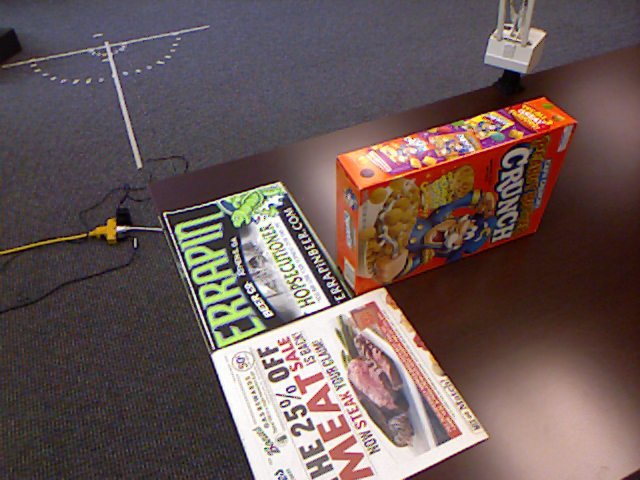

In [46]:
import cv2

def select_reference_image(images):
    # Create an AKAZE feature detector
    detector = cv2.AKAZE_create()

    # Initialize variables to store the best reference image and its similarity score
    best_reference_image = None
    best_similarity_score = 0

    # Extract keypoints and descriptors for each image
    keypoints = []
    descriptors = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, desc = detector.detectAndCompute(gray_img, None)
        keypoints.append(kp)
        descriptors.append(desc)

    # Match keypoints and compute similarity score
    for i in range(len(images)):
        similarity_score = 0
        for j in range(len(images)):
            if i != j:
                # Create a brute-force matcher object
                matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

                # Match keypoints and compute number of matches
                matches = matcher.match(descriptors[i], descriptors[j])
                similarity_score += len(matches)

        # Update the best reference image and similarity score
        if similarity_score > best_similarity_score:
            best_similarity_score = similarity_score
            best_reference_image = images[i]

    return best_reference_image

# Example usage
# Assume 'images' is a list of 5 different object view images
reference_image = select_reference_image(images)
cv2_imshow( reference_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [37]:
def match_keypoints(images):
    # Define parameters for feature detection
    n_octaves = 3
    n_scales = 30

    # Create a feature detector and matcher object
    detector = cv2.AKAZE_create(descriptor_type=cv2.AKAZE_DESCRIPTOR_MLDB_UPRIGHT,
                                threshold=0.0001, nOctaves=n_octaves, nOctaveLayers=n_scales)
    matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)

    # Compute keypoints and descriptors for all images
    keypoints = []
    descriptors = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, desc = detector.detectAndCompute(gray, None)
        keypoints.append(kp)
        descriptors.append(desc)

    # Match keypoints between camera views
    matches_list = []
    for i in range(len(images) - 1):
        matches = matcher.match(descriptors[i], descriptors[i+1])
        matches = sorted(matches, key=lambda x: x.distance)

        src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Find homography matrix using RANSAC
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Transform source points to destination points using the homography matrix
        transformed_pts = cv2.perspectiveTransform(src_pts, H)

    

        

    return transformed_pts
